# Customer Segmentation

### Libraries:
Import necessary libraries and modules:  
**Data manipulation**:
* `Pandas`
* `NumPy`
  
**Visualisation**:
* `Matplotlib`
* `Seaborn`
* `Missingno`  

**Machine Learning and preprocssing**:  
* `Scikit-learn`  


In [1]:
import os
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as no
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Ignore warning messages
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Iterate through the '/kaggle/input' directory and its subdirectories
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # Print the full file path of each file
        print(os.path.join(dirname, filename))

/kaggle/input/customer-segmentation-dataset/Online Retail.xlsx


### Load Data

In [3]:
data  = pd.read_excel('/kaggle/input/customer-segmentation-dataset/Online Retail.xlsx', sheet_name='Online Retail')

### Explortary Data Analysis (EDA)  
EDA techniques are applied to gain insights into the dataset, identify patterns, and understand the distribution of variables.

In [4]:
data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

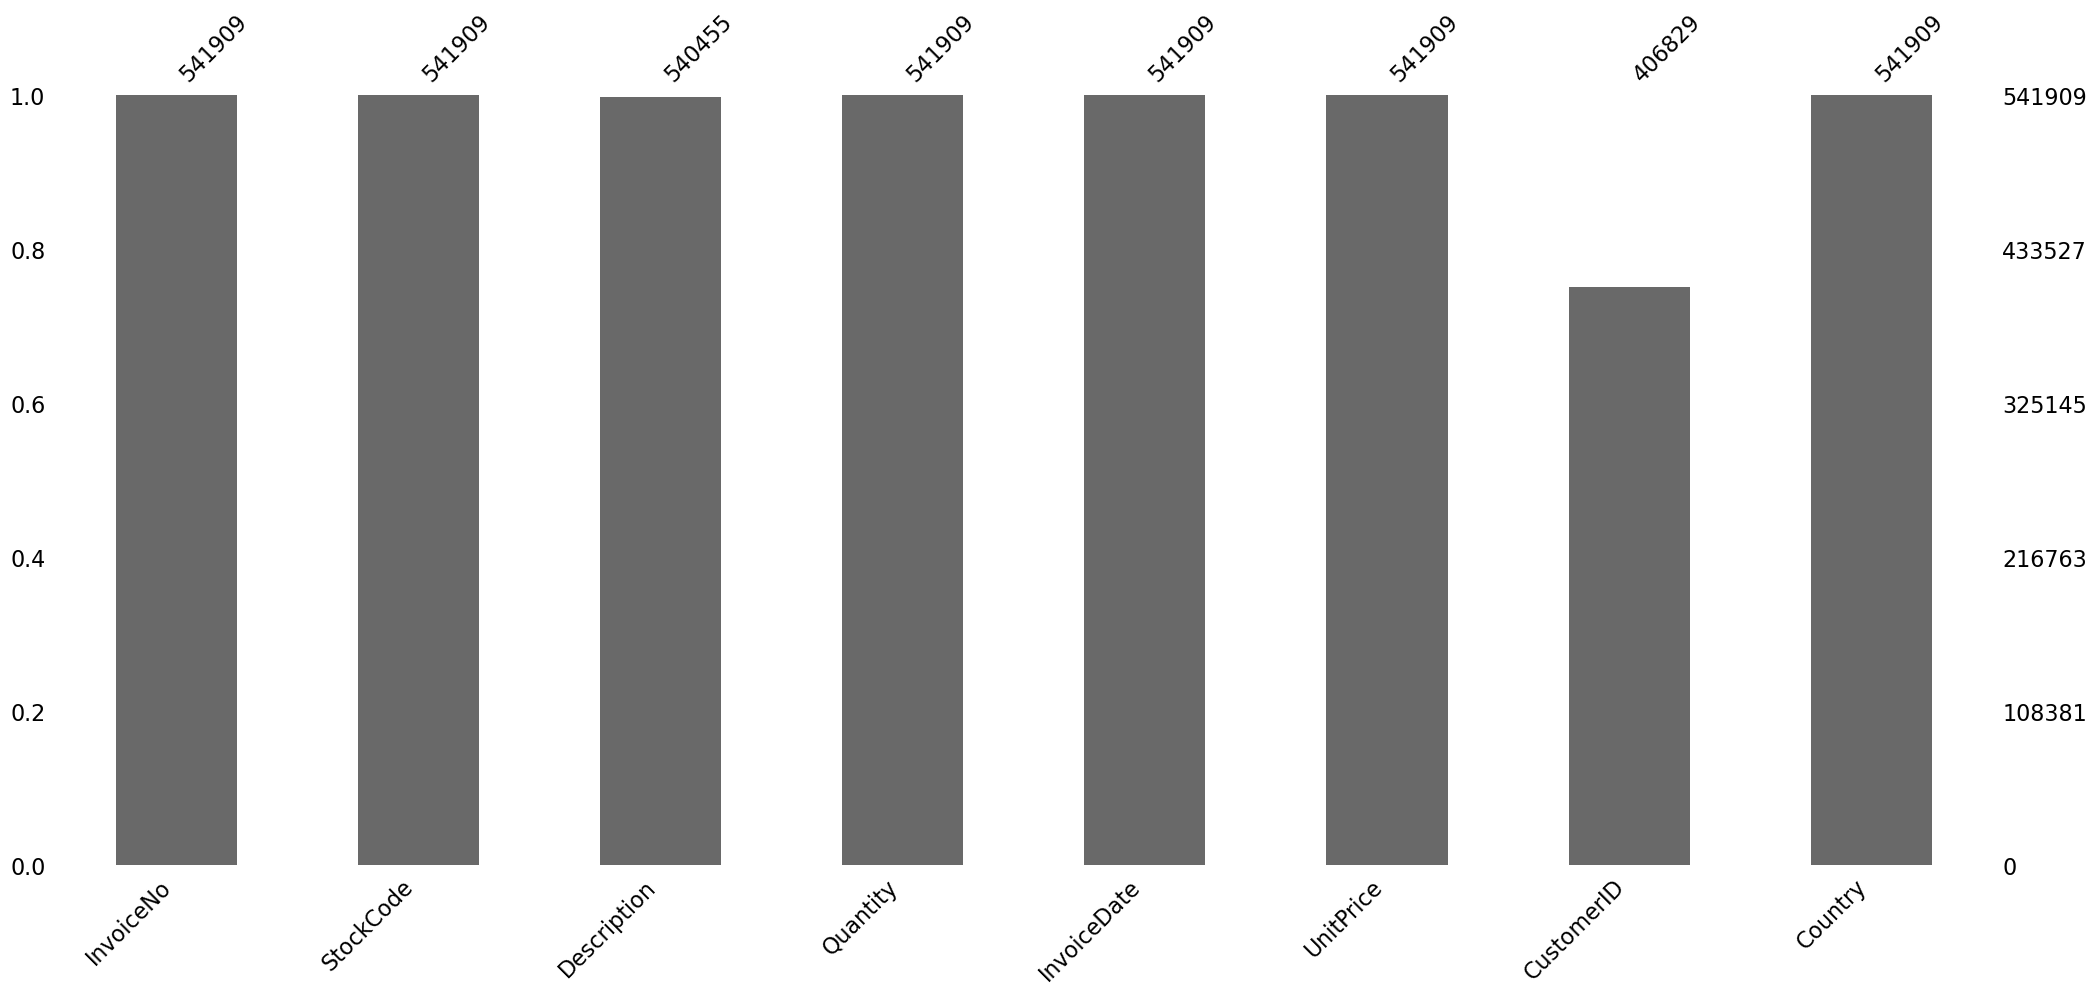

In [13]:
no.bar(data)
plt.show()

In [16]:
# Calculate the percentage of missing data in the CustomerID column
print(f'Percentage of missing data from CustomerID column is: {round(data.CustomerID.isna().sum() / data.shape[0] *100,2)}%')

Percentage of missing data from CustomerID column is: 24.93%


Missing values are detected, primarily in the `CustomerID` column and `Description` column. The percentage of missing data in the CustomerID column is calculated, revealing the extent of the data quality issue.


Before removing null values from the 'Description' column, we can replace those null values with a placeholder value to indicate that the description information is missing. This step ensures that we retain the information about missing descriptions and can still use it in our analysis.

In [17]:
data['Description'].fillna('No Description', inplace=True)

In [18]:
data['Description'].isna().sum()

0

Let's remove of any null values that may be present within the dataset.

In [19]:
df = data.dropna()

In [20]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [21]:
df.shape

(406829, 8)

In [22]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


We notice that there are negative values in the `Quantity` column and a value of zero in `UnitPrice` column . let's assume that we consulted stakeholders and they confirmed that these negative values are a result of typographical errors, and the correct values should be positive. As a result, we will consider only the positive values in the `Quantity` column for our analysis and further processing. And they have confirmed that the zero `UnitPrice` values are invalid entries or represent missing data. As per their guidance, we will proceed by removing these records from the dataset.

In [23]:
df['Quantity'] = df['Quantity'].abs()

In [24]:
df.drop(df[df['UnitPrice'] == 0].index, axis=0, inplace=True)

### Feature Engineering

Now that the dataset appears to be in good condition, our focus is shifting towards customer segmentation. In order to accomplish this, we will transform the current sales data into a customer-level perspective.

we will use the RFM marketing Metrics, to look at customer's behaviours based on:  
* **Recency**: How many days had passed since customer last purchased.
* **Frequency**: - How many times a customer had shopped here.
* **Monetary Value**: - How much money had the customer spent.

![RFM](https://d35fo82fjcw0y8.cloudfront.net/2018/03/01013508/Incontent_image.png)

Calculate the total price for each transaction: This step creates a new column named `TotalPrice` by multiplying the `Quantity` and `UnitPrice` columns. It calculates the total monetary value for each transaction, which can be useful for customer segmentation.

In [25]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

Find the most recent date in the dataset: Identifying the most recent date in the `InvoiceDate` column helps in calculating the recency of customer transactions.

##### **Why we didn't use `Country` column?**  
When dealing with categorical variables like the `Country` column in a dataset with a large number of unique categories (37 countries in this case), it is essential to consider the appropriate approach for handling such data.  
Using the `Country` column directly as a feature in clustering algorithms like K-means might not be the best approach because it could lead to a high-dimensional feature space and potential inefficiencies in the clustering process. The large number of unique categories may introduce noise and make it challenging for the algorithm to identify meaningful patterns.
If you believe that the `Country` information is essential for segmentation, you could consider aggregating countries into broader regions or continents. This way, you reduce the number of categories while still capturing regional trends.  

  Group the data by `CustomerID` and calculate Recency, Frequency, and Monetary values: This step groups the data by `CustomerID` and calculates three important metrics : recency (the number of days between the most recent date and the maximum `InvoiceDate` for each customer), frequency (the count of invoices for each customer), and monetary value (the sum of the `TotalPrice` for each customer).

In [26]:
most_recent_date = df['InvoiceDate'].max()
customer_df = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (most_recent_date - x.max()).days,
                                            'InvoiceNo': 'count',
                                            'TotalPrice': 'sum'})
customer_df.rename(columns={'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'TotalPrice':'Monetary'}, inplace=True)
customer_df.head(5)

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,2,154367.20
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


In [27]:
customer_df.shape

(4371, 3)

In [28]:
customer_df.describe()

,Recency,Frequency,Monetary
count,4371.000000,4371.000000,4371.000000
mean,91.064974,93.065431,2178.620452
std,100.770046,232.463777,10503.405397
min,0.000000,1.000000,1.250000
25%,16.000000,17.000000,308.760000
50%,49.000000,42.000000,678.010000
75%,142.000000,102.000000,1696.910000
max,373.000000,7983.000000,336942.100000


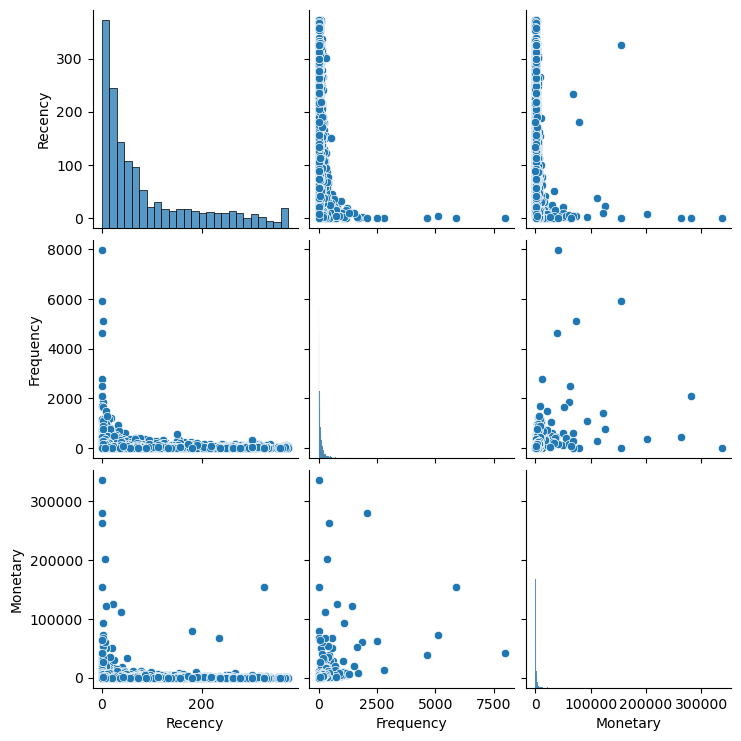

In [29]:
sns.pairplot(customer_df)

Standardize the customer dataframe using StandardScaler: Standardizing the data using StandardScaler ensures that all the variables are on the same scale, which is necessary for K-means clustering.

In [30]:
scaler = StandardScaler()
norm_df = scaler.fit_transform(customer_df)
norm_df

array([[ 2.32173944e+00, -3.91785125e-01,  1.44911089e+01],
       [-8.93869573e-01,  3.82617649e-01,  2.02945932e-01],
       [-1.69365072e-01, -2.67020234e-01, -3.63143258e-02],
       ...,
       [-8.34321258e-01, -3.44460512e-01, -1.90352471e-01],
       [-8.74020134e-01,  2.85210205e+00, -7.97360753e-03],
       [-4.86956086e-01, -9.92329664e-02, -3.25017927e-02]])

### Model Building

Performs K-means clustering with different numbers of clusters (ranging from 1 to 10)

In [31]:
inertia = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(norm_df)
    inertia.append(kmeans.inertia_)

Plot the inertia values 

Text(0, 0.5, 'Inertia')

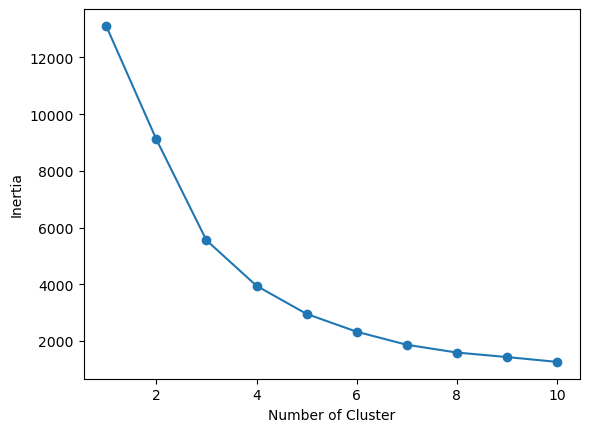

In [32]:
plt.plot(range(1,11), 
         inertia,
         marker='o')
plt.xlabel('Number of Cluster')
plt.ylabel('Inertia')

K-means clustering is performed with different numbers of clusters, and we think `3` is the most appropriate value for number of clusters.

Lets validate our findings using silhouette score

In [33]:
sil = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(norm_df)
    sil.append(silhouette_score(norm_df, kmeans.labels_))

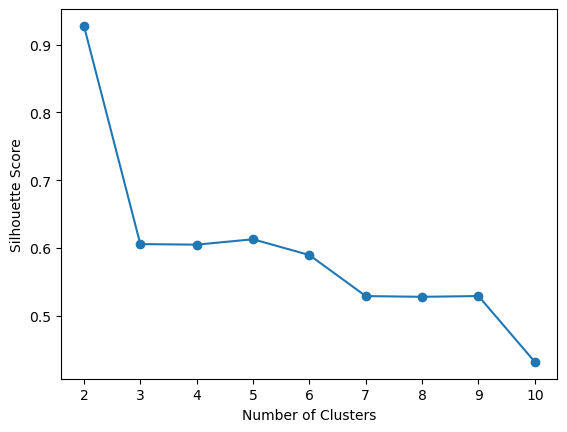

In [34]:
plt.plot(range(2,11), sil, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

The silhouette scores for 3, 4, and 5 clusters were approximately similar. However, the inertia value significantly decreased from 3 to 4 clusters and  relatively less when moving from 4 to 5 clusters. Consequently, we selected 3 clusters as the optimal number for customer segmentation.

### Further Analysis and Interpretation

Analyze The segmented customer data in more detail to understand the characteristics and behaviors of each customer segment.

Perform K-means clustering with the final number of clusters

In [35]:
final_kmeans = KMeans(n_clusters=3,random_state=42)
final_kmeans.fit(norm_df)


KMeans(n_clusters=3, random_state=42)

Create a new dataframe with customer information and assigned clusters

In [36]:
final_df = pd.DataFrame(customer_df, columns=customer_df.columns, index=customer_df.index)
final_df['Cluster'] = final_kmeans.labels_ + 1 # I want to have cluster labels starting from 1 instead of 0
final_df.head(10)

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,325,2,154367.20,3
12347.0,1,182,4310.00,1
12348.0,74,31,1797.24,1
12349.0,18,73,1757.55,1
12350.0,309,17,334.40,2
12352.0,35,95,3466.67,1
12353.0,203,4,89.00,2
12354.0,231,58,1079.40,2
12355.0,213,13,459.40,2


Visualize the distribution of clusters 

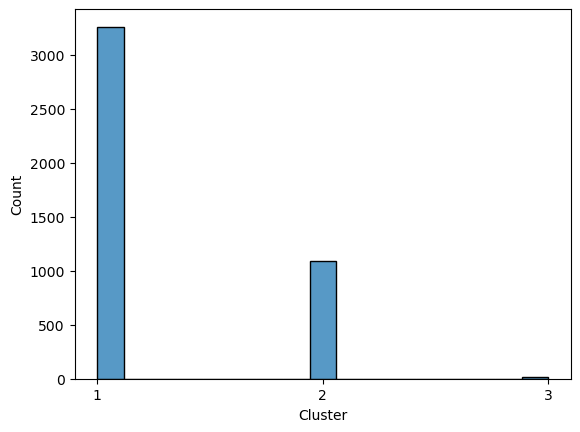

In [37]:
sns.histplot(final_df.Cluster)
plt.xticks(range(1,4))
plt.show()

In [38]:
final_df.groupby('Cluster').agg({'Monetary':'mean',
                                 'Frequency':'mean',
                                 'Recency':'mean'})

,Monetary,Frequency,Recency
Cluster,,,
1,2081.217484,104.846413,39.318210
2,561.131089,27.753199,246.232176
3,141329.410000,2294.533333,27.400000


After segmenting the customer data into three distinct clusters, we conducted a detailed analysis to comprehend the unique characteristics and behaviors exhibited by each group. The segmentation revealed clear patterns in terms of customer recency, purchase frequency, and monetary value.  
* **Cluster 1: "High-Value Regular Customers"**:  
This cluster consists of customers with relatively high monetary value, moderate frequency, and recent transactions. They are likely to be loyal and valuable customers who make regular purchases.  

* **Cluster 2: "Low-Value Occasional Customers**"
This cluster includes customers with lower monetary value, lower frequency, and higher recency. They might be occasional buyers who make infrequent purchases.  

* **Cluster 3: "High-Value VIP Customers**"  
This cluster represents customers with exceptionally high monetary value, high frequency, and very recent transactions. They are top-tier customers who contribute significantly to the business's revenue and should be treated as VIPs.